In [1]:
import tensorflow as tf
import sys, imageio, os,keras
from keras import backend
sys.path.append("/Users/kai/Downloads/graduation/final_git/MasterThesis/src/")
from model import *
from data_prepare import *
from plot import *

In [2]:
X, y = data("20221116_Plate21")
y = y*2
X_train,y_train = data("varying_lum_and_focus_train")
X_test,y_test = data("varying_lum_and_focus_test")

In [3]:
X_combine = np.concatenate([X_train,X_test,X], axis=0)
y_combine = np.concatenate([y_train,y_test,y], axis=0)

In [4]:
# Make sure the train, validation, test set is 60,20,20.
X_train, X_test, y_train, y_test = train_test_split(X_combine, y_combine, test_size=0.2, random_state=42,shuffle=True)
X_train, X_val, y_train , y_val  = train_test_split(X_train, y_train, test_size=0.25  , random_state=42,shuffle=True)

In [5]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape, X_val.shape,y_val.shape

((1391, 120), (1391, 1), (464, 120), (464, 1), (464, 120), (464, 1))

In [7]:
def build_model(hp):
    # input_size = hp.Fixed("input", 120)
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(120, 1)))
    model.add(keras.layers.Rescaling(1 / 127.5, offset=-1))
    for i in range(hp.Int("num_conv_layers", 1, 4, default=2)):
        model.add(keras.layers.Conv1D(
            filters=hp.Int(f"filters_{i + 1}", min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[10,11,12,13,14,15,16, 17,18,19,20]),
            activation="relu",
            name=f"conv_{i + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
    hp_pooling = hp.Choice(f'pooling_{i}', values=["MP", "AP", "No pool"])
    hp_padding = hp.Choice('padding_' + str(i), values=['valid', 'same'])
    if hp_pooling == "MP":
        model.add(keras.layers.MaxPooling1D(hp.Int(f"MP", min_value=1, max_value=4, step=1),padding = hp_padding))
    if hp_pooling == "AP":
        model.add(keras.layers.AveragePooling1D(hp.Int(f"AP", min_value=1, max_value=4, step=1),padding = hp_padding))
    if hp.Boolean("batch_normalization", default=False):
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    for j in range(hp.Int("num_dense_layers", 1, 4, default=2)):
        model.add(keras.layers.Dense(
            units=hp.Int("dense_size", min_value=8, max_value=256, step=32), activation="relu",
            name=f"dense_{j + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
        model.add(keras.layers.Dropout(hp.Float(f"dropout_{j + 1}", 0, 0.5, step=0.1, default=0.2)))
    model.add(keras.layers.Dense(units=1, activation=None, name="output"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log", default=1e-3)),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    return model
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        # "no longer improving" being defined as "no better than 1e-3 less"
        # "no longer improving" being further defined as "for at least 3 epochs"
        monitor="val_mean_absolute_error",
        min_delta=1e-3,
        patience=3,
        verbose=1),]
def hp_model_output_information(model,X_train,y_train,X_test,y_test):
    """
    This function is get the output from hp.
    
    model              : object, for evaluate the model
    X                  : array, for feature for the model
    y                  : array, for label for the model
    X_test             : array, for feature for the model
    y_test             : array, for label for the model
    
    return             : model, object of trained model
                         list, objects of history for recording of training loss values and metrics values.
                         list, objects of the evaluate result.
    """
    best_model, best_model_hp, history= evaluate_hp_model(model,X_train,y_train,X_test,y_test)
    evaluate_epoch(history,type="loss")
    evaluate_epoch(history,type="mae")
    compare_predict_extact(best_model,X_test,y_test)
    return best_model, best_model_hp, history

In [ ]:
tuner_BO = tuning_model(build_model, callbacks, 
                        X_train, y_train, X_val, y_val,
                        model_type="BO", 
                        project=model_path+"CNN_combine_BO_without_crop")
best_model, best_model_hp, history = hp_model_output_information(tuner_BO,X_train, y_train, X_test, y_test)
best_model.save(model_path+"bin2_BO_without_crop_best_model_val_version")

In [6]:
model = load_model(model_path,"bin2_BO_without_crop_best_model_val_version")
config = model.get_config()
lr = backend.get_value(model.optimizer.lr)
new_model = keras.Sequential().from_config(config)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

In [7]:
trained_model, historys, evaluations = evaluate_model(new_model, X_train, y_train, X_test,y_test,lr,120,n_split = 3,shuffle=True,random_state=42)
acc = np.mean(np.array(evaluations),axis=0)[1]
print(acc)

Epoch 1/60


2023-04-05 00:55:58.161465: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


186/186 [==============================] - 4s 17ms/step - loss: 7.9510 - mean_absolute_error: 2.0535 - val_loss: 22.7156 - val_mean_absolute_error: 4.0523
Epoch 2/60
186/186 [==============================] - 3s 17ms/step - loss: 4.0037 - mean_absolute_error: 1.4214 - val_loss: 15.3416 - val_mean_absolute_error: 3.2490
Epoch 3/60
186/186 [==============================] - 3s 17ms/step - loss: 3.6676 - mean_absolute_error: 1.3617 - val_loss: 8.6026 - val_mean_absolute_error: 2.2142
Epoch 4/60
186/186 [==============================] - 3s 17ms/step - loss: 3.4577 - mean_absolute_error: 1.3120 - val_loss: 2.7581 - val_mean_absolute_error: 1.1253
Epoch 5/60
186/186 [==============================] - 3s 17ms/step - loss: 3.3048 - mean_absolute_error: 1.2706 - val_loss: 2.4949 - val_mean_absolute_error: 1.0622
Epoch 6/60
186/186 [==============================] - 3s 17ms/step - loss: 3.2230 - mean_absolute_error: 1.2598 - val_loss: 3.2621 - val_mean_absolute_error: 1.2622
Epoch 7/60
186/186 

In [8]:
evaluations

[[2.332136631011963, 1.0629637241363525],
 [1.9548866748809814, 0.9718178510665894],
 [1.85970139503479, 0.9772790670394897]]

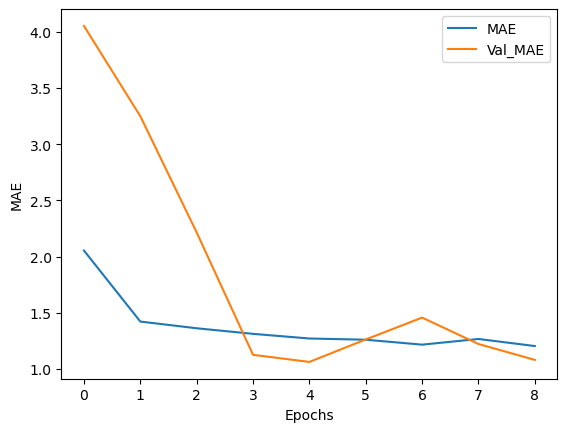

mae epoch plot execute!


In [9]:
evaluate_epoch(historys[0],type="mae")

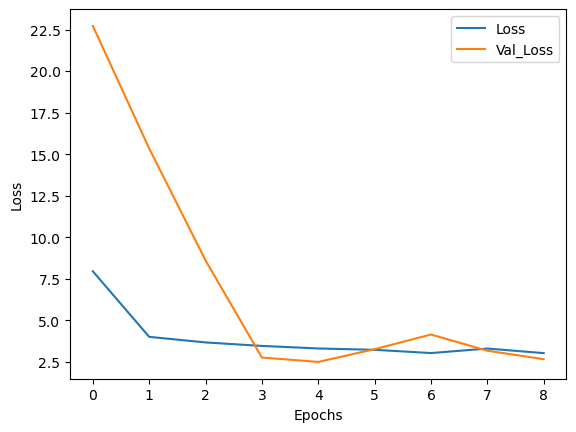

loss epoch plot execute!


In [10]:
evaluate_epoch(historys[0],type="loss")

In [11]:
crop_value=[120]
ME = statistic_evaluate([trained_model],X_test,y_test,crop_value,statistic_type="ME" ,n_iterations=1000,n_samples=30)
RE = statistic_evaluate([trained_model],X_test,y_test,crop_value,statistic_type="RE" ,n_iterations=1000,n_samples=30)
MAE= statistic_evaluate([trained_model],X_test,y_test,crop_value,statistic_type="MAE",n_iterations=1000,n_samples=30)

Get 564 time(s) 0 in label.
Get 582 time(s) 0 in label, so it will not include in the output.
Get 584 time(s) 0 in label.


Text(0.5, 0, 'Mean Error')

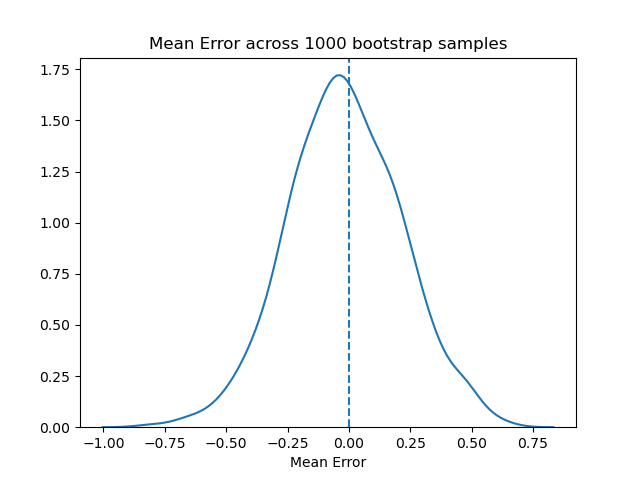

In [12]:
%matplotlib widget
import seaborn as sns
i=0
sns.kdeplot(ME[i])
plt.title("Mean Error across 1000 bootstrap samples")
plt.axvline(0,linestyle="--")
plt.xlabel("Mean Error")

Text(0.5, 0, 'Relative Error')

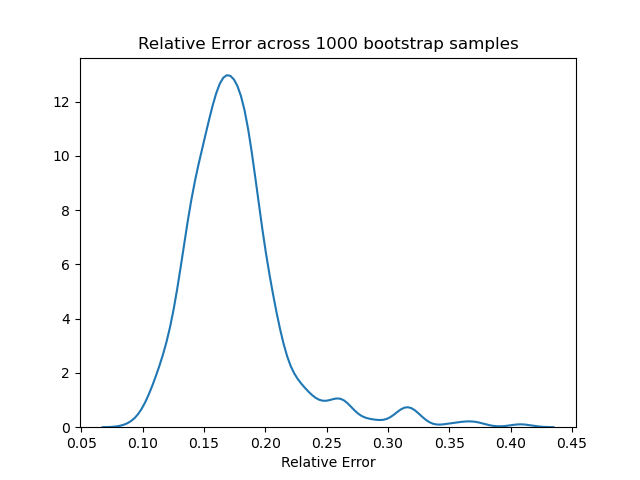

In [13]:
%matplotlib widget
i=0
sns.kdeplot(RE[i])
plt.title("Relative Error across 1000 bootstrap samples")
plt.xlabel("Relative Error")

Text(0.5, 0, 'MAE')

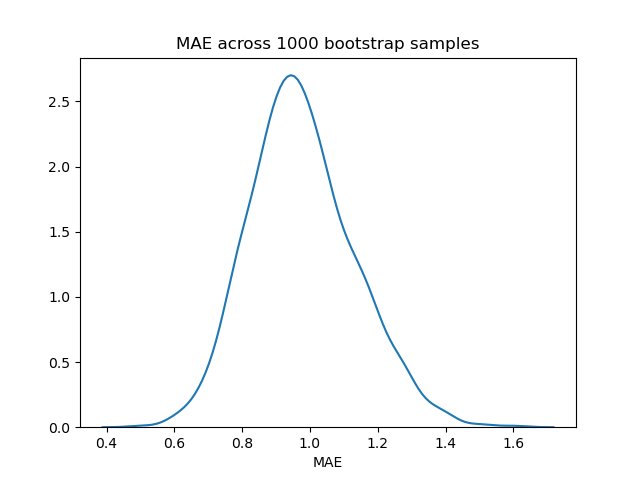

In [14]:
%matplotlib widget
i=0
sns.kdeplot(MAE[i])
plt.title("MAE across 1000 bootstrap samples")
plt.xlabel("MAE")